# Clustering analysis using PCA


What you will find in here:
- [Clustering Analysis](#Clustering)
- [Variance](#Variance)

In [21]:
#Load all my imports necessary 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, f1_score
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

In [22]:
order_products_train= pd.read_csv("../data/order_products__train.csv")
order_products_prior = pd.read_csv("../data/order_products__prior.csv")
orders = pd.read_csv("../data/orders.csv")
products = pd.read_csv("../data/products.csv")
aisles = pd.read_csv("../data/aisles.csv")
departments = pd.read_csv("../data/departments.csv")
orders_train_all = pd.read_csv("../data/orders_train_all.csv")

# Randomly selecting some of the data

PCA wouldn't run with the number of rows and columns in the original dataframe, so I created a smaller subset from the dataframe I created with all my engineered features

In [24]:
#subsetting from the prior eval set
priors = orders.loc[orders['eval_set']=='prior']

#looking at unique user ID's
prior_users = priors['user_id'].unique().tolist()

#gathering a smaller, random sample from the original set 
#in order to conduct a PCA and have it not take 10 million years
random_prior = random.sample(range(len(prior_users)), 25000)


#new users and the random subset mapped onto each other
users_prior = [prior_users[i] for i in random_prior]

#iterating through user id and making sure it's in the new subset dataframe
sample_orders = orders[orders['user_id'].isin(random_prior)]

#creating a list of orders within this new dataframe
orders_list = sample_orders['order_id'].unique().tolist()

In [25]:
orders_train_all.shape

(3597584, 23)

In [26]:
orders_train_all.head()

,product_id,product_name,aisle_id,department_id,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,...,average_orders,average_order_dow,average_order_hour,weekend,rate_reordered,department,aisle,aisle_cat,dept_cat,product_cat
0,1,Chocolate Sandwich Cookies,61,19,1107,7,0.0,38259,prior,2,...,0.0,0.0,0.0,1,0.0,snacks,cookies cakes,0,0,NaN
1,1,Chocolate Sandwich Cookies,61,19,7540,4,1.0,138499,prior,8,...,0.0,0.0,0.0,1,0.0,snacks,cookies cakes,0,0,NaN
2,1,Chocolate Sandwich Cookies,61,19,9228,2,0.0,79603,prior,2,...,0.0,0.0,0.0,0,0.0,snacks,cookies cakes,0,0,NaN
3,1,Chocolate Sandwich Cookies,61,19,9273,30,0.0,50005,prior,1,...,0.0,0.0,0.0,1,0.0,snacks,cookies cakes,0,0,NaN
4,1,Chocolate Sandwich Cookies,61,19,9696,5,1.0,108919,prior,46,...,0.0,0.0,0.0,0,0.0,snacks,cookies cakes,0,0,NaN


In [27]:
priors_sample = orders_train_all[orders_train_all["order_id"].isin(orders_list)]
priors_sample.shape

(566215, 23)

In [29]:
priors_sample.head()

,product_id,product_name,aisle_id,department_id,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,...,average_orders,average_order_dow,average_order_hour,weekend,rate_reordered,department,aisle,aisle_cat,dept_cat,product_cat
2,1,Chocolate Sandwich Cookies,61,19,9228,2,0.0,79603,prior,2,...,0.0,0.0,0.0,0,0.000000,snacks,cookies cakes,0,0,NaN
22,1,Chocolate Sandwich Cookies,61,19,47122,6,1.0,38748,prior,16,...,0.0,0.0,0.0,1,0.714286,snacks,cookies cakes,0,0,NaN
29,1,Chocolate Sandwich Cookies,61,19,56811,1,1.0,113429,prior,17,...,0.0,0.0,0.0,0,1.000000,snacks,cookies cakes,0,0,NaN
30,1,Chocolate Sandwich Cookies,61,19,57503,3,1.0,111982,prior,76,...,0.0,0.0,0.0,1,0.000000,snacks,cookies cakes,0,0,NaN
31,1,Chocolate Sandwich Cookies,61,19,58691,14,1.0,144159,prior,3,...,0.0,0.0,0.0,0,0.000000,snacks,cookies cakes,0,0,NaN


In [28]:
priors_sample.to_csv('../data/priors_sample.csv')

<a id='Clustering'></a>
# Now to the clustering analysis

In [7]:
features = ['product_id', 'aisle_id', 'department_id', 'order_id',
       'add_to_cart_order', 'user_id', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'average_orders', 'average_order_dow', 'average_order_hour', 'weekend',
       'rate_reordered', 'aisle_cat', 'dept_cat']

#Features
X = priors_sample[features]
y = priors_sample.reordered

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                 random_state = 42,
                 stratify = y)

In [9]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/Users/maithilijoshi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/maithilijoshi/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/maithilijoshi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#instantiate and fit a PCA model
pca = PCA()
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [11]:
#Place PCA into XGBoost
xg = XGBClassifier(max_depth = 12, 
                  min_child_weight= 3,
                   random_state=42)

xg.fit(X_train_pca, y_train)

y_pred = xg.predict(X_test_pca)

In [12]:
print("F1 Score: %.2f%%" % round((f1_score(y_test, y_pred)* 100)))

F1 Score: 79.00%


<a id='Variance'></a>
# Explained Variance

- 83.3% of our variance can be explained by 10 of our variables

In [13]:
var_exp = pca.explained_variance_ratio_
print(f'Explained variance: {np.round(var_exp,3)}')

#cumulative variance explained
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance: {np.round(cum_var_exp,3)}')

Explained variance: [0.179 0.108 0.088 0.084 0.078 0.075 0.06  0.059 0.057 0.046 0.043 0.042
 0.033 0.027 0.01  0.008 0.003]
Cumulative explained variance: [0.179 0.286 0.374 0.458 0.537 0.612 0.672 0.731 0.787 0.833 0.876 0.918
 0.952 0.979 0.989 0.997 1.   ]


So, it turns out that clustering doesn't do much better than XGBoost alone.

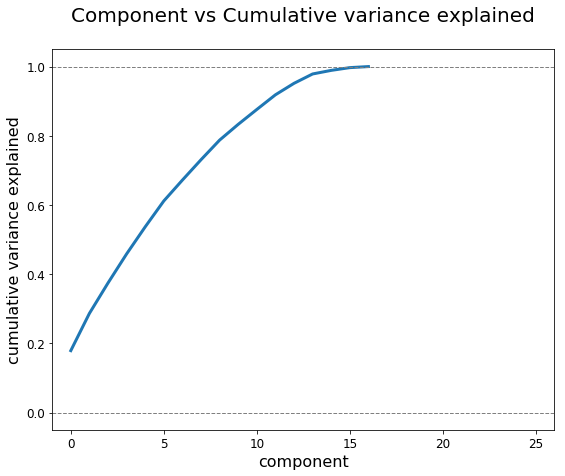

In [14]:
#from lesson 8.4
plt.figure(figsize=(9,7))

# Plot the cumulative explained variance
component_number = range(len(cum_var_exp))
plt.plot(component_number, cum_var_exp, lw=3)

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([-1,26])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('Component vs Cumulative variance explained\n', fontsize=20)

plt.show()